# This notebook is meant  to show what happens to the Ising Model when turning on a nonzero magnetic field, "h". Results are plotted from 10x10 lattices at different values of h which were run previously, using KbT_list = np.arange(0.2,10.2,0.2). But of course one can do their own investigations with this notebook

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot

class Direction:
    """
    Initialize directionality of 2D Ising model
    """
    Right, Top, Left, Bottom = range(4)
    
class Ising2D(object):
    """
    Initialize 2D Ising object on which we will apply the metropolis algorithm
    """
    def __init__ (self, L, J, KbT, h):
        
        """
        Initialize Ising quantities and structure (Kb = 1) 
        """
        self.L = L # Length of 2D model (in points)
        self.N = L**2 # Total number of points in Ising model
        self.KbT = KbT# Thermal Energy (Joules) 
        self.beta = 1./KbT # For convenience, define beta = 1/[J]
        self.J = J # Exchange Constant J - for J > 0 aligned spins are favored, and visa versa
        self.h = h #Uniform external magnetic field strength
        
        #Initialize all spin positions, and makes sure they are integer valued:
        self.positions = np.zeros((self.L,self.L),dtype=np.int32)
        self.x = np.zeros(self.N,dtype=np.int32)
        self.y = np.zeros(self.N,dtype=np.int32)
        
        #Initialize the nearest neighbors for each position:
        self.nn = np.zeros((self.N,4),dtype=np.int32)
        
        """
        Initialize nearest neighbors and impose BC's
        """
        
        k = 0
        #**? changed these from being x_k <-> y_k - This fixed it
        for y_k in range(L):
            for x_k in range(L):
                #Define positions
                self.positions[y_k,x_k] = k
                self.x[k] = x_k
                self.y[k] = y_k
                #Define nearest neighbors
                self.nn[k,Direction.Left] = k-1
                self.nn[k,Direction.Right] = k+1
                self.nn[k,Direction.Bottom] = k-L
                self.nn[k,Direction.Top] = k+L # k plus whole row
                
                #Implement Periodic Boundary Conditions for nn:
                
                #**? Changed these fromg being += statements
                if x_k == 0: #when at leftmost side of grid:
                    
                    # Shift left nn to rightmost side of grid +(L col spaces)
                    self.nn[k,Direction.Left] += L # or (k-1)+L
                    
                if x_k == L-1: #when at rightmost side of grid:
                    
                    # Shift right nn to leftmost side of grid -(L col spaces)
                    self.nn[k,Direction.Right] -= L # or (k+1)-L
                    
                if y_k == 0: #when at bottom of grid:
                    
                    # Shift bottom nn to top of grid, +(L cols over)*(L rows up)
                    self.nn[k,Direction.Bottom] += L**2 # or (k-L)+L**2 
                    
                if y_k == L-1: #when at top of grid:
                    
                    # Shift top nn to bottom of grid, -(L cols over)*(L rows down)
                    self.nn[k,Direction.Top] -= L**2 # or (k+L)-L**2
                    
                k += 1   #advance to next iteration
                
                
        """
        Now we Initialize spins, magnetization, and transition probabilities
        """  
        
        
        rand = 2*np.random.random(self.N)-1 #randomly distributed from 0-1 so shift down so avg val is 0.
        
        #We can default to a random configuration of spins (can always be reset later)
        self.spins = np.ones(self.N, dtype=np.int32)
        for i in range(self.N):
            if (rand[i] < 0):
                self.spins[i] *= -1 #flip the spin
                
        self.M_total = np.sum(self.spins) # Def of Magnetization
        
        self.E = 0. # Initialize energy to 0
        for i in range(self.N):
            #sum up total energy contributed by each spin
            #Note importantly that we only sum over the right and top spins. This is so that we don't end up counting the same interaction twice
            self.E += -self.J*self.spins[i]*(self.spins[self.nn[i,Direction.Right]]+self.spins[self.nn[i,Direction.Top]])
        #Add energy contributed by uniform external magnetic field
        self.E += -self.h*self.M_total
            
        """
        Now we initialize matrices where we will store all possible dE's and then all possible Boltzmann Probabilities: BP. 
        This will allow us to avoid calculating them each iteration.
        
        We then can then create a function whose purpose is to calculate these quantities for a give temperature.
        I will call this Temp(), and it will also serve the purpose of setting self.T
        """ 
        
        self.dE = np.zeros((3,9)) 
        self.RP = np.zeros((3,9))  
        self.ThermE(self.KbT)
        
    def ThermE(self,KbT):
        
        self.KbT = KbT
        self.beta = 1./(KbT)
        
        #Next we populate the dE and Boltzmann Probability (BP) matrices (Commonly denoted as W):
        for i in range(-4,5): 
            #deltaU is 2*U, negative when spin in question is -1, positive when spin is +1.
            #We first setup the coefficients for the nearest-neighbor interaction energies
            #We can just use these, plus the dE from the mag field (added later) to determine the initial flip condition
            self.dE[0,i+4] = 2.*self.J*i
            self.dE[2,i+4] = -2.*self.J*i
            p_temp = np.exp(-self.beta*self.dE[0,i+4])
            #Note the (-) in the exponential of p_temp, so dE is E_init - E_trial, RelProb (RP) = P_trial/P_initial
            #If this is greater than a uniform random number, we will accept the new trial configuration
            
            #Now we will define the relative probailities which will determine the random number flip condition; We can cap probabilities at 1.
            if p_temp < 1.:
                self.RP[0,i+4] = p_temp
                self.RP[2,i+4] = 1./p_temp
            else:
                self.RP[2,i+4] = 1.
                self.RP[0,i+4] = 1.
                
    """
    We will now implement the Metropolis algorithm
    """
    
    def Metropolis(self):
        #initialize the number of configuration changes
        n_config_changes = 0
        
        for n in range(self.N):
            #Begin by generating a trial configuration
            #First we choose a random lattice point, k (and force it to be an integer)
            #We do this by generating a uniform random number and multiplying that by the total number of lattice points 
            k = int(np.random.random()*self.N)
            
            #Next, we define the nearest neighbors for k
            k_right = self.nn[k,Direction.Right]
            k_left = self.nn[k,Direction.Left]
            k_top = self.nn[k,Direction.Top]
            k_bot = self.nn[k,Direction.Bottom]
            
            #Next compute the sum of the nearest neighbor's spins, and flip the spin we're at (trial)
            spins_sum = self.spins[k_right]+self.spins[k_left]+self.spins[k_top]+self.spins[k_bot]
            s = self.spins[k]
            
            #flip spin for trial
            s *= -1 
            #Now we compute the change in nearest-neighbor energy from our dE matrix
            
            #It should be clear now why the dE matrix was 3x9 rather than 2x9 (spin will be -1 or 1, leading this to pick out rows 1 or 3)
            deltaE = self.dE[s+1,spins_sum+4]
            
            #Access the relative boltzmann probability from the RP matrices
            RelProb = self.RP[s+1,spins_sum+4]
            
            #Now we can add the energy change contributed by the uniform mag field interaction with the spin change
            
            h_deltaE = self.h*(2*s)
            
            deltaE += h_deltaE
            
            #Add energy change contribution from mag field to relative probability

            RelProb *= np.exp(-self.beta*h_deltaE)
            
            #spin flip is accepted if either dE <= 0 or if a uniformly distributed random number is smaller than the relative boltzmann probability
            if deltaE <=0. or RelProb > np.random.random():
                #accept spin flip
                self.spins[k] = s
                #update total magnetization after new spin
                self.M_total += 2*s
                #update total energy with energy change
                self.E += deltaE
                #add a counter to the number of configuration changes
                n_config_changes += 1
        return n_config_changes
# Define time functions to keep track of runtime
from time import time
tstart_list=[]

def tick():
    tstart_list.append(time())
    
def toc():
    print("Time Passed:",time()-tstart_list.pop(),"s") #.pop() is a nice way to grab the last element of your list

Now we add a uniform magnetic field, strength h, to see what happens.

In [4]:
KbT_list = np.arange(0.2,10.2,0.2)
E_t_h0 = [-2.     , -2.     , -2.     , -1.99944, -1.99828, -1.98712,
       -1.97052, -1.92924, -1.86108, -1.75132, -1.62304, -1.44992,
       -1.26644, -1.08324, -0.94464, -0.80212, -0.7026 , -0.62308,
       -0.55512, -0.50868, -0.45556, -0.4062 , -0.37932, -0.3606 ,
       -0.32468, -0.30304, -0.29416, -0.2722 , -0.26408, -0.24684,
       -0.22624, -0.22056, -0.2182 , -0.20692, -0.20052, -0.19484,
       -0.17868, -0.175  , -0.1688 , -0.1658 , -0.15436, -0.15664,
       -0.15636, -0.1356 , -0.13696, -0.13948, -0.13524, -0.13644,
       -0.13152, -0.13084]
M_t_h0 = [1.     , 1.     , 1.     , 0.99986, 0.99956, 0.99654, 0.9921 ,
       0.97986, 0.95928, 0.92174, 0.87466, 0.8033 , 0.72712, 0.6426 ,
       0.57174, 0.5037 , 0.44918, 0.405  , 0.3692 , 0.33698, 0.30444,
       0.28052, 0.26212, 0.2503 , 0.23142, 0.21908, 0.21236, 0.1978 ,
       0.18936, 0.18416, 0.17302, 0.17114, 0.16152, 0.15902, 0.1564 ,
       0.15118, 0.14516, 0.14468, 0.14046, 0.13574, 0.13912, 0.13524,
       0.12804, 0.12684, 0.12606, 0.12194, 0.11888, 0.1187 , 0.12174,
       0.11376]
M_t_h2 = [1.     , 1.     , 0.99746, 0.98716, 0.96468, 0.93248, 0.89052,
       0.8448 , 0.80076, 0.75292, 0.707  , 0.6675 , 0.62606, 0.59456,
       0.55368, 0.524  , 0.49258, 0.46172, 0.44088, 0.42002, 0.395  ,
       0.3735 , 0.35636, 0.33874, 0.32808, 0.32156, 0.30364, 0.29476,
       0.2706 , 0.26876, 0.2609 , 0.2425 , 0.2433 , 0.2322 , 0.22276,
       0.22174, 0.2086 , 0.19814, 0.20126, 0.18792, 0.19002, 0.18272,
       0.18114, 0.17524, 0.17492, 0.1724 , 0.16636, 0.16504, 0.15518,
       0.15742]
E_t_h2 = [-3.92   , -3.92   , -3.90476, -3.84324, -3.71088, -3.52484,
       -3.28992, -3.04524, -2.8168 , -2.57628, -2.36236, -2.17904,
       -1.99616, -1.8672 , -1.70784, -1.58988, -1.46956, -1.3496 ,
       -1.27004, -1.20144, -1.11376, -1.04432, -0.98092, -0.91976,
       -0.88524, -0.86424, -0.80212, -0.77964, -0.7042 , -0.6968 ,
       -0.67392, -0.61728, -0.61404, -0.58672, -0.55068, -0.53792,
       -0.51144, -0.48472, -0.48512, -0.44324, -0.4472 , -0.43016,
       -0.42248, -0.40336, -0.3924 , -0.38932, -0.36516, -0.36136,
       -0.34176, -0.34712]
M_t_h_2 = [1.     , 1.     , 1.     , 1.     , 1.     , 0.99988, 0.99984,
       0.99904, 0.9974 , 0.99546, 0.99094, 0.98522, 0.97912, 0.96648,
       0.95392, 0.93924, 0.9241 , 0.90484, 0.88048, 0.8613 , 0.83918,
       0.8081 , 0.77884, 0.75652, 0.72648, 0.70096, 0.67056, 0.64572,
       0.61754, 0.59902, 0.57862, 0.55872, 0.53402, 0.50954, 0.4939 ,
       0.47754, 0.4517 , 0.43788, 0.4252 , 0.40864, 0.40302, 0.38618,
       0.37292, 0.36156, 0.35166, 0.33746, 0.32962, 0.32354, 0.31416,
       0.29874]
E_t_h_2 = [-4.08   , -4.08   , -4.08   , -4.08   , -4.08   , -4.07928,
       -4.07904, -4.07428, -4.06452, -4.05304, -4.02672, -3.99336,
       -3.95808, -3.88752, -3.8166 , -3.73696, -3.65824, -3.55508,
       -3.42976, -3.33552, -3.22568, -3.07612, -2.9418 , -2.83472,
       -2.70288, -2.58468, -2.45172, -2.34608, -2.2294 , -2.153  ,
       -2.07128, -1.9822 , -1.88588, -1.78808, -1.72884, -1.66956,
       -1.57112, -1.5144 , -1.46752, -1.40508, -1.385  , -1.3264 ,
       -1.27336, -1.23228, -1.20548, -1.15484, -1.12   , -1.0974 ,
       -1.067  , -1.01144]
M_t_h10 = [1.     , 1.     , 1.     , 1.     , 1.     , 1.     , 0.99996,
       1.     , 1.     , 0.99994, 0.99976, 0.99956, 0.99926, 0.99864,
       0.99744, 0.99584, 0.99386, 0.99208, 0.98952, 0.98662, 0.98312,
       0.97898, 0.9739 , 0.96944, 0.96332, 0.95764, 0.9508 , 0.9461 ,
       0.93704, 0.9278 , 0.92372, 0.91836, 0.90964, 0.89982, 0.88814,
       0.88134, 0.87702, 0.86638, 0.85748, 0.8489 , 0.83932, 0.83366,
       0.8174 , 0.81118, 0.80804, 0.7931 , 0.78684, 0.77692, 0.76708,
       0.76478]
E_t_h10 = [-8.     , -8.     , -8.     , -8.     , -8.     , -8.     ,
       -7.99944, -8.     , -8.     , -7.99916, -7.99664, -7.99384,
       -7.98964, -7.98096, -7.96416, -7.94176, -7.91404, -7.88932,
       -7.85352, -7.81296, -7.76408, -7.70672, -7.63632, -7.5742 ,
       -7.48924, -7.41064, -7.31596, -7.25148, -7.12624, -6.99844,
       -6.94528, -6.87208, -6.75264, -6.61704, -6.4602 , -6.36756,
       -6.30948, -6.1646 , -6.04564, -5.93088, -5.80232, -5.72892,
       -5.51172, -5.42692, -5.38804, -5.19064, -5.10512, -4.97728,
       -4.84984, -4.81456]
E_t_h_10 = [-12.4    , -12.4    , -12.4    , -12.4    , -12.4    , -12.4    ,
       -12.4    , -12.4    , -12.4    , -12.39972, -12.4    , -12.39972,
       -12.39944, -12.39804, -12.39832, -12.3958 , -12.39104, -12.38964,
       -12.37872, -12.37032, -12.36448, -12.35524, -12.33736, -12.31432,
       -12.29164, -12.25548, -12.24324, -12.21416, -12.16888, -12.13392,
       -12.0722 , -12.0318 , -11.96908, -11.9372 , -11.89152, -11.80744,
       -11.75876, -11.68524, -11.60228, -11.54468, -11.45612, -11.35264,
       -11.28232, -11.20404, -11.093  , -11.07352, -10.93356, -10.83924,
       -10.76912, -10.6278 ]
M_t_h_10 = [1.     , 1.     , 1.     , 1.     , 1.     , 1.     , 1.     ,
       1.     , 1.     , 0.99998, 1.     , 0.99998, 0.99996, 0.99986,
       0.99988, 0.9997 , 0.99936, 0.99926, 0.99848, 0.99788, 0.99746,
       0.9968 , 0.99552, 0.99386, 0.99224, 0.98964, 0.98878, 0.98668,
       0.98342, 0.98088, 0.97642, 0.97348, 0.96898, 0.9667 , 0.9634 ,
       0.95726, 0.95376, 0.94836, 0.94228, 0.938  , 0.93154, 0.92398,
       0.9187 , 0.91278, 0.90482, 0.90324, 0.89284, 0.88582, 0.88058,
       0.8699 ]

C:\Users\cpeac\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cpeac\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  """


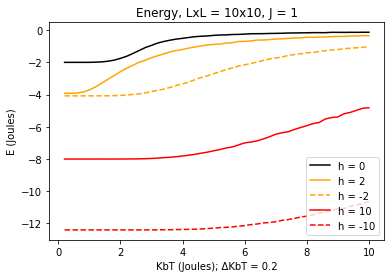

In [5]:
pyplot.plot(KbT_list,E_t_h0,ls='-',color='black',label='h = 0')
pyplot.plot(KbT_list,E_t_h2,ls='-',color='orange',label='h = 2')
pyplot.plot(KbT_list,E_t_h_2,ls='-',color='orange',label='h = -2',linestyle='--')
pyplot.plot(KbT_list,E_t_h10,ls='-',color='red',label='h = 10')
pyplot.plot(KbT_list,E_t_h_10,ls='-',color='red',label='h = -10',linestyle='--')
#pyplot.errorbar(KbT_list,E_t,yerr=[E_standdev,E_standdev], fmt='--o',color='orange')
pyplot.ylabel("E (Joules)")
pyplot.xlabel("KbT (Joules); ΔKbT = 0.2")
pyplot.title("Energy, LxL = 10x10, J = 1")
pyplot.legend()

C:\Users\cpeac\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  """Entry point for launching an IPython kernel.
C:\Users\cpeac\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


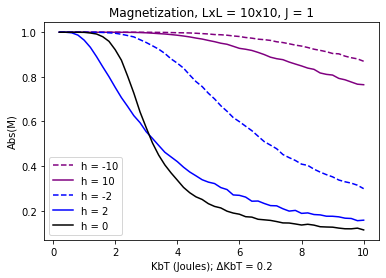

In [6]:
pyplot.plot(KbT_list,M_t_h_10,ls='-',color='purple',label='h = -10',linestyle='--')
pyplot.plot(KbT_list,M_t_h10,ls='-',color='purple',label='h = 10')
pyplot.plot(KbT_list,M_t_h_2,ls='-',color='blue',label='h = -2',linestyle='--')
pyplot.plot(KbT_list,M_t_h2,ls='-',color='blue',label='h = 2')
pyplot.plot(KbT_list,M_t_h0,ls='-',color='black',label='h = 0')
#pyplot.errorbar(KbT_list,M_t,yerr=[M_standdev,M_standdev], fmt='--o',color='blue')
pyplot.ylabel("Abs(M)")
pyplot.xlabel("KbT (Joules); ΔKbT = 0.2")
pyplot.title("Magnetization, LxL = 10x10, J = 1")
pyplot.legend()

Here's an example investiation of the h = 2 case:

In [9]:
tick()

KbT_list = np.arange(0.2,10.2,0.2) #Initialize T array we will run over

#Initialize the arrays for E,M,E^2,M^2 for each run at given T
M_t = np.zeros(len(KbT_list))
Msq_t = np.zeros(len(KbT_list))
E_t = np.zeros(len(KbT_list))
Esq_t = np.zeros(len(KbT_list))

#Initialize another 2D Ising
N_Iterations = 1000
N_deCorrelation = 3
L = 10
N_Initialize = L*L
J = 1.
h = 2.
My_Ising2D = Ising2D(L,J,KbT_list[0],h) #using first temp

print("2D Ising Simulation with L =",L,", J =",J,":")
#Now we run the loop (here the Temp func proves its usefulness):
k = 0
n_accepted_configs = 0
for KbT in KbT_list:
    My_Ising2D.ThermE(KbT)
    for i in range(N_Initialize):
        My_Ising2D.Metropolis() #Initialize spin configuration
            
    for i in range(N_Iterations):
        for j in range(N_deCorrelation):
            n_accepted_configs += My_Ising2D.Metropolis()
        E_t[k] += My_Ising2D.E
        Esq_t[k] += My_Ising2D.E**2
        M_t[k] += abs(My_Ising2D.M_total)
        Msq_t[k] += abs(My_Ising2D.M_total)**2
        
    print("KbT =",round(KbT,2),": Energy =",E_t[k]/(N_Iterations*My_Ising2D.N),"J, and Mag =",M_t[k]/(N_Iterations*My_Ising2D.N))
    k += 1
    
#Divide out the number of metropolis iterations and lattice points
M_t /= float(N_Iterations*My_Ising2D.N)
Msq_t /= float(N_Iterations*My_Ising2D.N**2)
E_t /= float(N_Iterations*My_Ising2D.N)
Esq_t /= float(N_Iterations*My_Ising2D.N**2)
E_standdev = np.sqrt(abs(Esq_t-E_t**2)/N_Iterations)
M_standdev = np.sqrt(abs(Msq_t-M_t**2)/N_Iterations)

print("Acceptence Ratio =",float(n_accepted_configs)/(len(KbT_list)*My_Ising2D.N*N_Iterations*N_deCorrelation))

toc()

2D Ising Simulation with L = 10 , J = 1.0 :
KbT = 0.2 : Energy = -3.52 J, and Mag = 1.0
KbT = 0.4 : Energy = -3.51904 J, and Mag = 0.99984
KbT = 0.6 : Energy = -3.505 J, and Mag = 0.9975
KbT = 0.8 : Energy = -3.4402 J, and Mag = 0.98664
KbT = 1.0 : Energy = -3.3066 J, and Mag = 0.96396
KbT = 1.2 : Energy = -3.12288 J, and Mag = 0.93226
KbT = 1.4 : Energy = -2.88828 J, and Mag = 0.89054
KbT = 1.6 : Energy = -2.65368 J, and Mag = 0.84684
KbT = 1.8 : Energy = -2.41432 J, and Mag = 0.80028
KbT = 2.0 : Energy = -2.17568 J, and Mag = 0.75174
KbT = 2.2 : Energy = -1.95532 J, and Mag = 0.70508
KbT = 2.4 : Energy = -1.75876 J, and Mag = 0.6619
KbT = 2.6 : Energy = -1.60216 J, and Mag = 0.62622
KbT = 2.8 : Energy = -1.43436 J, and Mag = 0.58458
KbT = 3.0 : Energy = -1.29796 J, and Mag = 0.55418
KbT = 3.2 : Energy = -1.18944 J, and Mag = 0.52384
KbT = 3.4 : Energy = -1.08328 J, and Mag = 0.49722
KbT = 3.6 : Energy = -0.94448 J, and Mag = 0.4621
KbT = 3.8 : Energy = -0.8792 J, and Mag = 0.44196
Kb

Text(0.5, 1.0, '2D Ising, J = 1, h = 2')

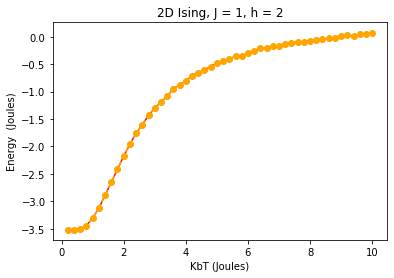

In [10]:
%matplotlib inline
pyplot.plot(KbT_list,E_t,ls='-',color='red')
pyplot.errorbar(KbT_list,E_t,yerr=[E_standdev,E_standdev], fmt='--o',color='orange')
pyplot.ylabel("Energy  (Joules)")
pyplot.xlabel("KbT (Joules)")
pyplot.title("2D Ising, J = 1, h = 2")

Text(0.5, 1.0, '2D Ising, J = 1, h = 2')

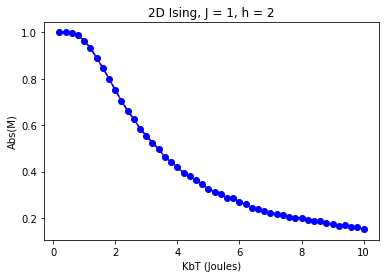

In [11]:

pyplot.plot(KbT_list,M_t,ls='-',color='purple')
pyplot.errorbar(KbT_list,M_t,yerr=[M_standdev,M_standdev], fmt='--o',color='blue')
pyplot.ylabel("Abs(M)")
pyplot.xlabel("KbT (Joules)")
pyplot.title("2D Ising, J = 1, h = 2")

Text(0.5, 1.0, '2D Ising, J = 1, h = 2')

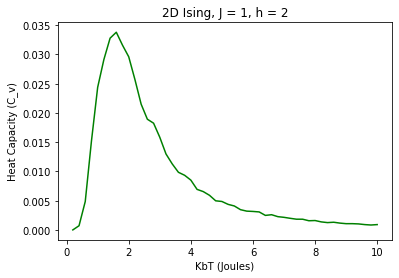

In [12]:
pyplot.plot(KbT_list,((Esq_t-E_t**2)/(KbT_list)**2),ls='-',color='green')
pyplot.ylabel("Heat Capacity (C_v)")
pyplot.xlabel("KbT (Joules)")
pyplot.title("2D Ising, J = 1, h = 2")

Text(0.5, 1.0, '2D Ising, J = 1, h = 10')

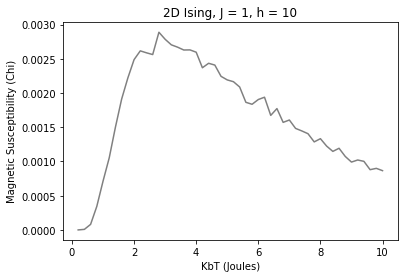

In [13]:
pyplot.plot(KbT_list,((Msq_t-M_t**2)/(KbT_list)),ls='-',color='grey')
pyplot.ylabel("Magnetic Susceptibility (Chi)")
pyplot.xlabel("KbT (Joules)")
pyplot.title("2D Ising, J = 1, h = 10")

In [14]:
print("The maximum C_v occurs at KbT =",KbT_list[np.argmax(((Esq_t-E_t**2)/(KbT_list)**2))])

The maximum C_v occurs at KbT = 1.6


Adding in an external magnetic field smoothes out the phase transition so that it is not as sharp, though generally the same behavior is observed as before.

In [15]:
tick()

KbT_list = np.arange(0.2,10.2,0.2) #Initialize T array we will run over

#Initialize the arrays for E,M,E^2,M^2 for each run at given T
M_t = np.zeros(len(KbT_list))
Msq_t = np.zeros(len(KbT_list))
E_t = np.zeros(len(KbT_list))
Esq_t = np.zeros(len(KbT_list))

#Initialize another 2D Ising
N_Iterations = 1000
N_deCorrelation = 3
L = 10
N_Initialize = L*L
J = 1.
h = -2.
My_Ising2D = Ising2D(L,J,KbT_list[0],h) #using first temp

print("2D Ising Simulation with L =",L,", J =",J,":")
#Now we run the loop (here the Temp func proves its usefulness):
k = 0
n_accepted_configs = 0
for KbT in KbT_list:
    My_Ising2D.ThermE(KbT)
    for i in range(N_Initialize):
        My_Ising2D.Metropolis() #Initialize spin configuration
            
    for i in range(N_Iterations):
        for j in range(N_deCorrelation):
            n_accepted_configs += My_Ising2D.Metropolis()
        E_t[k] += My_Ising2D.E
        Esq_t[k] += My_Ising2D.E**2
        M_t[k] += abs(My_Ising2D.M_total)
        Msq_t[k] += abs(My_Ising2D.M_total)**2
        
    print("KbT =",round(KbT,2),": Energy =",E_t[k]/(N_Iterations*My_Ising2D.N),"J, and Mag =",M_t[k]/(N_Iterations*My_Ising2D.N))
    k += 1
    
#Divide out the number of metropolis iterations and lattice points
M_t /= float(N_Iterations*My_Ising2D.N)
Msq_t /= float(N_Iterations*My_Ising2D.N**2)
E_t /= float(N_Iterations*My_Ising2D.N)
Esq_t /= float(N_Iterations*My_Ising2D.N**2)
E_standdev = np.sqrt(abs(Esq_t-E_t**2)/N_Iterations)
M_standdev = np.sqrt(abs(Msq_t-M_t**2)/N_Iterations)



print("Acceptence Ratio =",float(n_accepted_configs)/(len(KbT_list)*My_Ising2D.N*N_Iterations*N_deCorrelation))

toc()

2D Ising Simulation with L = 10 , J = 1.0 :
KbT = 0.2 : Energy = -3.68 J, and Mag = 1.0
KbT = 0.4 : Energy = -3.68 J, and Mag = 1.0
KbT = 0.6 : Energy = -3.68 J, and Mag = 1.0
KbT = 0.8 : Energy = -3.68 J, and Mag = 1.0
KbT = 1.0 : Energy = -3.67976 J, and Mag = 0.99996
KbT = 1.2 : Energy = -3.67976 J, and Mag = 0.99996
KbT = 1.4 : Energy = -3.67748 J, and Mag = 0.99958
KbT = 1.6 : Energy = -3.67368 J, and Mag = 0.99894
KbT = 1.8 : Energy = -3.6632 J, and Mag = 0.99718
KbT = 2.0 : Energy = -3.651 J, and Mag = 0.9951
KbT = 2.2 : Energy = -3.6256 J, and Mag = 0.99078
KbT = 2.4 : Energy = -3.59452 J, and Mag = 0.9853
KbT = 2.6 : Energy = -3.55 J, and Mag = 0.97774
KbT = 2.8 : Energy = -3.49568 J, and Mag = 0.96774
KbT = 3.0 : Energy = -3.41952 J, and Mag = 0.95438
KbT = 3.2 : Energy = -3.34452 J, and Mag = 0.94034
KbT = 3.4 : Energy = -3.24896 J, and Mag = 0.92232
KbT = 3.6 : Energy = -3.16328 J, and Mag = 0.90646
KbT = 3.8 : Energy = -3.04668 J, and Mag = 0.88362
KbT = 4.0 : Energy = -2.

Text(0.5, 1.0, '2D Ising, J = 1, h = -10')

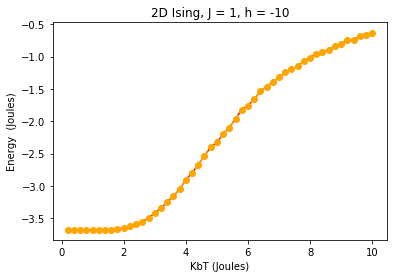

In [16]:

pyplot.plot(KbT_list,E_t,ls='-',color='red')
pyplot.errorbar(KbT_list,E_t,yerr=[E_standdev,E_standdev], fmt='--o',color='orange')
pyplot.ylabel("Energy  (Joules)")
pyplot.xlabel("KbT (Joules)")
pyplot.title("2D Ising, J = 1, h = -10")

Text(0.5, 1.0, '2D Ising, J = 1, h = -2')

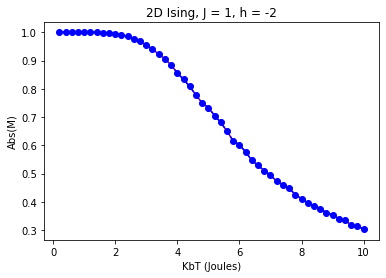

In [17]:

pyplot.plot(KbT_list,M_t,ls='-',color='purple')
pyplot.errorbar(KbT_list,M_t,yerr=[M_standdev,M_standdev], fmt='--o',color='blue')
pyplot.ylabel("Abs(M)")
pyplot.xlabel("KbT (Joules)")
pyplot.title("2D Ising, J = 1, h = -2")

Text(0.5, 1.0, '2D Ising, J = 1, h = -2')

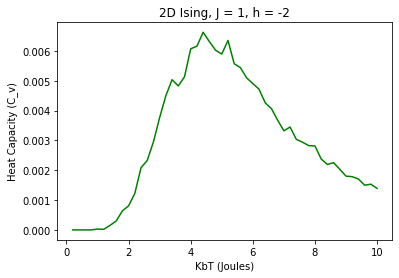

In [18]:
pyplot.plot(KbT_list,((Esq_t-E_t**2)/(KbT_list)**2),ls='-',color='green')
pyplot.ylabel("Heat Capacity (C_v)")
pyplot.xlabel("KbT (Joules)")
pyplot.title("2D Ising, J = 1, h = -2")

Text(0.5, 1.0, '2D Ising, J = 1, h = -2')

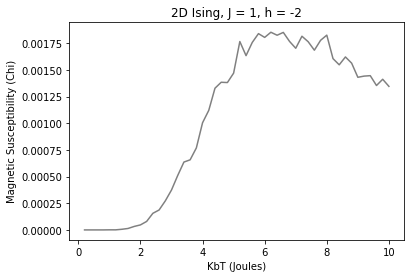

In [19]:
pyplot.plot(KbT_list,((Msq_t-M_t**2)/(KbT_list)),ls='-',color='grey')
pyplot.ylabel("Magnetic Susceptibility (Chi)")
pyplot.xlabel("KbT (Joules)")
pyplot.title("2D Ising, J = 1, h = -2")

In [20]:
print("The maximum C_v occurs at KbT =",KbT_list[np.argmax(((Esq_t-E_t**2)/(KbT_list)**2))])

The maximum C_v occurs at KbT = 4.4


One can see that the phase transition is similarly spread out, and there is no sharp peak in the c_v curve